# Common part

- Dataset 1 (general): [link](https://mavenanalytics.io/data-playground)
- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

tqdm.pandas()  # Registers the progress_apply method

COLOR = '#727272'
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['figure.dpi'] = 200

df = pd.read_csv(
    "../../../ufo_sightings_scrubbed.csv",
    low_memory=False
)

# Drop unnecessary columns
# df.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
df.drop(columns=['duration (hours/min)'], inplace=True)

# Rename columns
df.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Fix missing states
df.loc[df['country'].isna() & df['state'].notna(), 'country'] = 'us'
df.dropna(subset=['country', 'state'], how='all', inplace=True)

# Fix dates
df['datetime'] = pd.to_datetime(df['datetime'])
df['date posted'] = pd.to_datetime(df['date posted'])

# Fix numbers
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['duration'].dropna(inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = df['datetime'].dt.date > df['date posted'].dt.date
df.loc[mask, ['datetime', 'date posted']] = df.loc[mask, ['date posted', 'datetime']].values


# Shape mapping
shape_mappings = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing',
    np.nan: 'unknown'
}
df['shape'] = df['shape'].str.lower().map(shape_mappings)

# Remove incomplete year (2014)
df = df[df['datetime'].dt.year != 2014]

# Part 2

- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

## Alternative dataset

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv(
    "../../../nuforc_bool.csv",
).rename(columns={
    'Sighting': 'Row ID',
    'Text': 'Comments',
    'Occurred': 'Datetime',
    'Duration': 'Duration (text)',
}).set_index('Row ID')

df.drop(columns=['Summary', 'Posted'], inplace=True)
df.rename(columns={ 'Reported': 'Date Posted' }, inplace=True)
df['Shape'] = df['Shape'].str.lower().map(shape_mappings)

# Convert headings to lowercase
df.columns = df.columns.str.lower()

# Fix dates
timezone_mapping = {
    "Pacific": "PST",    
    "Eastern": "EST",    
    "Central": "CST",    
    "Mountain": "MST",   
    "UTC": "UTC",
    "GMT": "GMT",
    "Local": "",  # Remove 'local' to keep datetime naive
}

def map_timezone(s):
    if pd.isna(s):
        return s
    # Extract last word
    last_word = re.findall(r'\b(\w+)$', s)
    if last_word and last_word[0] in timezone_mapping:
        # Replace last word with mapped timezone
        return re.sub(r'\b\w+$', timezone_mapping[last_word[0]], s)
    return s

# TODO there are outlier dates! e.g. 1639
df['datetime'] = pd.to_datetime(df['datetime'].apply(map_timezone), errors='coerce')
df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))

# Extract duration in seconds using regex
# TODO use better technique
def extract_duration(duration):
    if not isinstance(duration, str):
        return np.nan
    # Match hours (e.g., "2 hours", "1hr")
    match_hr = re.search(r'(\d+)\s*hour', duration, re.IGNORECASE)
    if match_hr:
        return int(match_hr.group(1)) * 3600
    # Match minutes (e.g., "2 min", "20minutes")
    match_min = re.search(r'(\d+)\s*min', duration, re.IGNORECASE)
    if match_min:
        return int(match_min.group(1)) * 60
    # Match seconds (e.g., "30 seconds")
    match_sec = re.search(r'(\d+)\s*sec', duration, re.IGNORECASE)
    if match_sec:
        return int(match_sec.group(1))
    return np.nan

df['duration'] = df['duration (text)'].apply(extract_duration)

# Drop unnecessary columns and NAs
df.dropna(subset=['location', 'date posted', 'datetime'], inplace=True)

df_sent = df.dropna(subset=['comments']).copy()

/var/folders/gq/c0m9vgqx2_vflttb1fnkyw1r0000gn/T/ipykernel_1658/2561801776.py:45: FutureWarning: Parsed string "2014-10-23 11:11:17 PST" included an un-recognized timezone "PST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))


## NLT Pre-processing

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Only first time
# nltk.download('all')

df_sent = df.dropna(subset=['comments']).copy()

# Load resources once
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Updated preprocess_text function to handle all HTML-like codes
def preprocess_text(text, max_words=None):
    if not isinstance(text, str):
        return ""
    # Remove HTML-like codes using regex (e.g., &amp;, &#39;, etc.)
    # text = re.sub(r'&[#a-zA-Z0-9]+;', ' ', text)
    # Tokenize and truncate
    tokens = word_tokenize(text.lower())
    # Truncate if max_words is specified
    if max_words is not None:
        tokens = tokens[:max_words]
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Apply the updated function
df_sent['lemmatized comments'] = df_sent['comments'].progress_apply(lambda x: preprocess_text(x))

  0%|          | 0/130963 [00:00<?, ?it/s]

## NLT Sentiment analysis

### Method 1: Sentiment Analysis with BoW Model (Vader)
Problem: since text is short, 95% is neutral and 3% is compound

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Tresholding for sentiment
    sentiment = max(['pos', 'neu', 'neg'], key=lambda x: scores[x])
    return sentiment

# apply get_sentiment function
df_sent['sentiment'] = df_sent['lemmatized comments'].progress_apply(get_sentiment)

df_sent['sentiment'].value_counts()

  0%|          | 0/130963 [00:00<?, ?it/s]

sentiment
neu    130730
pos       184
neg        49
Name: count, dtype: int64

### Method 2: Sentiment Analsys with Pre-trained Transformer Model (BERT)

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=1,
    truncation=True,
	max_length=512
)

df_sent_sample = df_sent.sample(n=5000, random_state=42)
df_sent_sample['sentiment'] = df_sent_sample['comments'].progress_apply(
    lambda x: sentiment_pipeline(x)[0][0]['label']
)

# Visualizza i risultati
df_sent_sample[['comments', 'sentiment']]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Method 3: Emotional Analysis with cherry-picking words

In [ ]:
# Define a list of emotion-related keywords
emotion_keywords = [
    'fear', 'hopeful', 'shocked', 'confused', 'grateful',
    'scared', 'curious', 'sad', 'surprised', 'excited'
]

# Define a color for each emotion keyword
emotion_colors = {
    emotion_keywords[0]: '#f28b82',  # brighter pastel red
    emotion_keywords[1]: '#81c784',  # brighter pastel green
    emotion_keywords[2]: '#fff176',  # brighter pastel yellow
    emotion_keywords[3]: '#ba68c8',  # brighter pastel purple
    emotion_keywords[4]: '#4dd0e1',  # brighter pastel teal
    emotion_keywords[5]: '#ef5350',  # brighter pastel dark red
    emotion_keywords[6]: '#64b5f6',  # brighter pastel blue
    emotion_keywords[7]: '#90a4ae',  # brighter pastel dark blue
    emotion_keywords[8]: '#ffb74d',  # brighter pastel orange
    emotion_keywords[9]: '#ffcc80',  # brighter pastel gold
}

# Create a column for each emotion keyword (lemmatized)
for emotion in [lemmatizer.lemmatize(word) for word in emotion_keywords]:
    df_sent[emotion] = df_sent['lemmatized comments'].progress_apply(lambda x: emotion in x.lower() if isinstance(x, str) else False)

# Display the updated dataframe with the new emotion columns
df_sent[['comments'] + emotion_keywords]

# Count the number of rows for each emotion
df_sent[emotion_keywords].sum().sort_values()

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

grateful      255
sad           433
hopeful       494
confused      893
surprised    1234
shocked      1351
excited      1596
fear         1672
curious      1753
scared       3421
dtype: int64

### Method 4: Emotional Analsysis with model (RoBERTa)

In [58]:
from transformers import pipeline

# Use a faster emotion model and limit to 5,000 records
emotion_pipeline = pipeline(
    "text-classification",
    # model="cardiffnlp/twitter-roberta-base-emotion",
    model="j-hartmann/emotion-english-distilroberta-base", 
    top_k=1,
    truncation=True,
	max_length=512
)

# Limit records for speed
df_sent_sample = df_sent.sample(n=5000, random_state=42).copy()

# Apply the pipeline (truncate input for speed)
df_sent_sample['emotion'] = df_sent_sample['comments'].progress_apply(
    lambda x: emotion_pipeline(x)[0][0]['label']
)

df_sent_sample[['comments', 'emotion']]

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'sort_values'

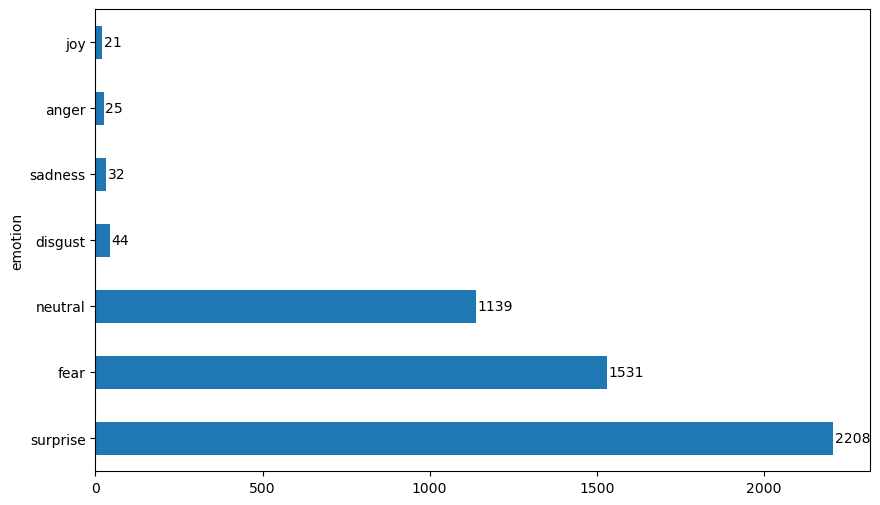

In [62]:
ax = df_sent_sample['emotion'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its value
for i, v in enumerate(df_sent_sample['emotion'].value_counts().sort_values(ascending=False)):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

## Visualizations (Method 2)
Chose this method because the others were too resource-intense and there are a lot of outliers in the text.

### Emotion vs Time of the Day
Apparently no relevant differences

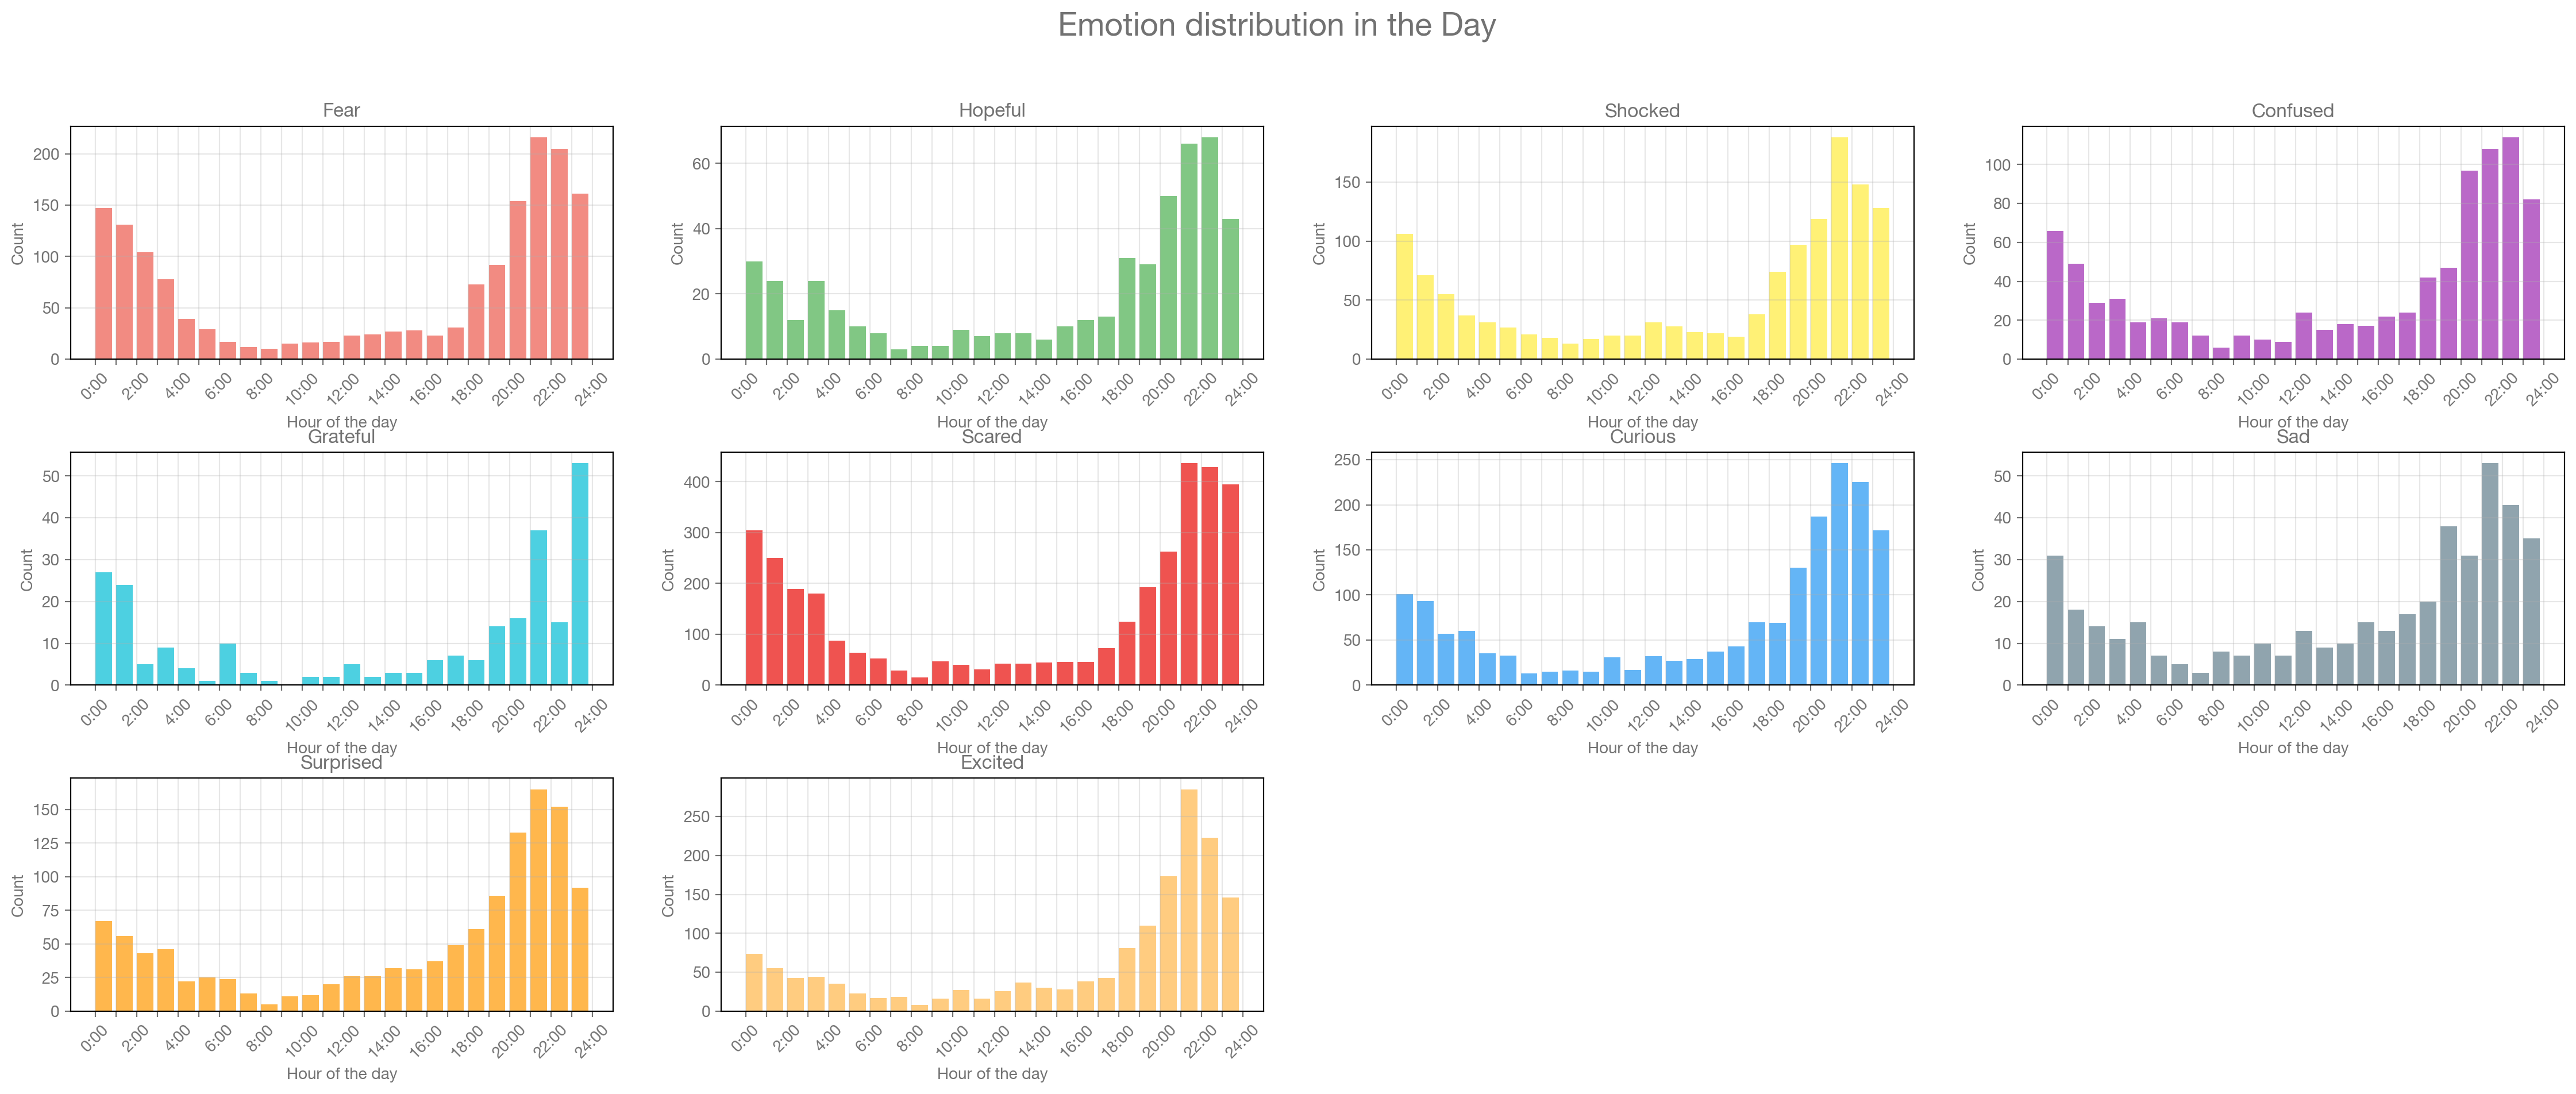

In [296]:
fig, axes = plt.subplots(3, 4, figsize=(28, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.hour.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['hour', 'count']
    
    ax.bar(
        df_emotion_count['hour'], 
        df_emotion_count['count'], 
        color=emotion_colors.get(e), 
        align="edge"
    )
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels([f"{h}:00" if h % 2 == 0 else "" for h in range(0, 25)], rotation=45)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Emotion distribution in the Day', fontsize=20)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

### Emotion vs Years

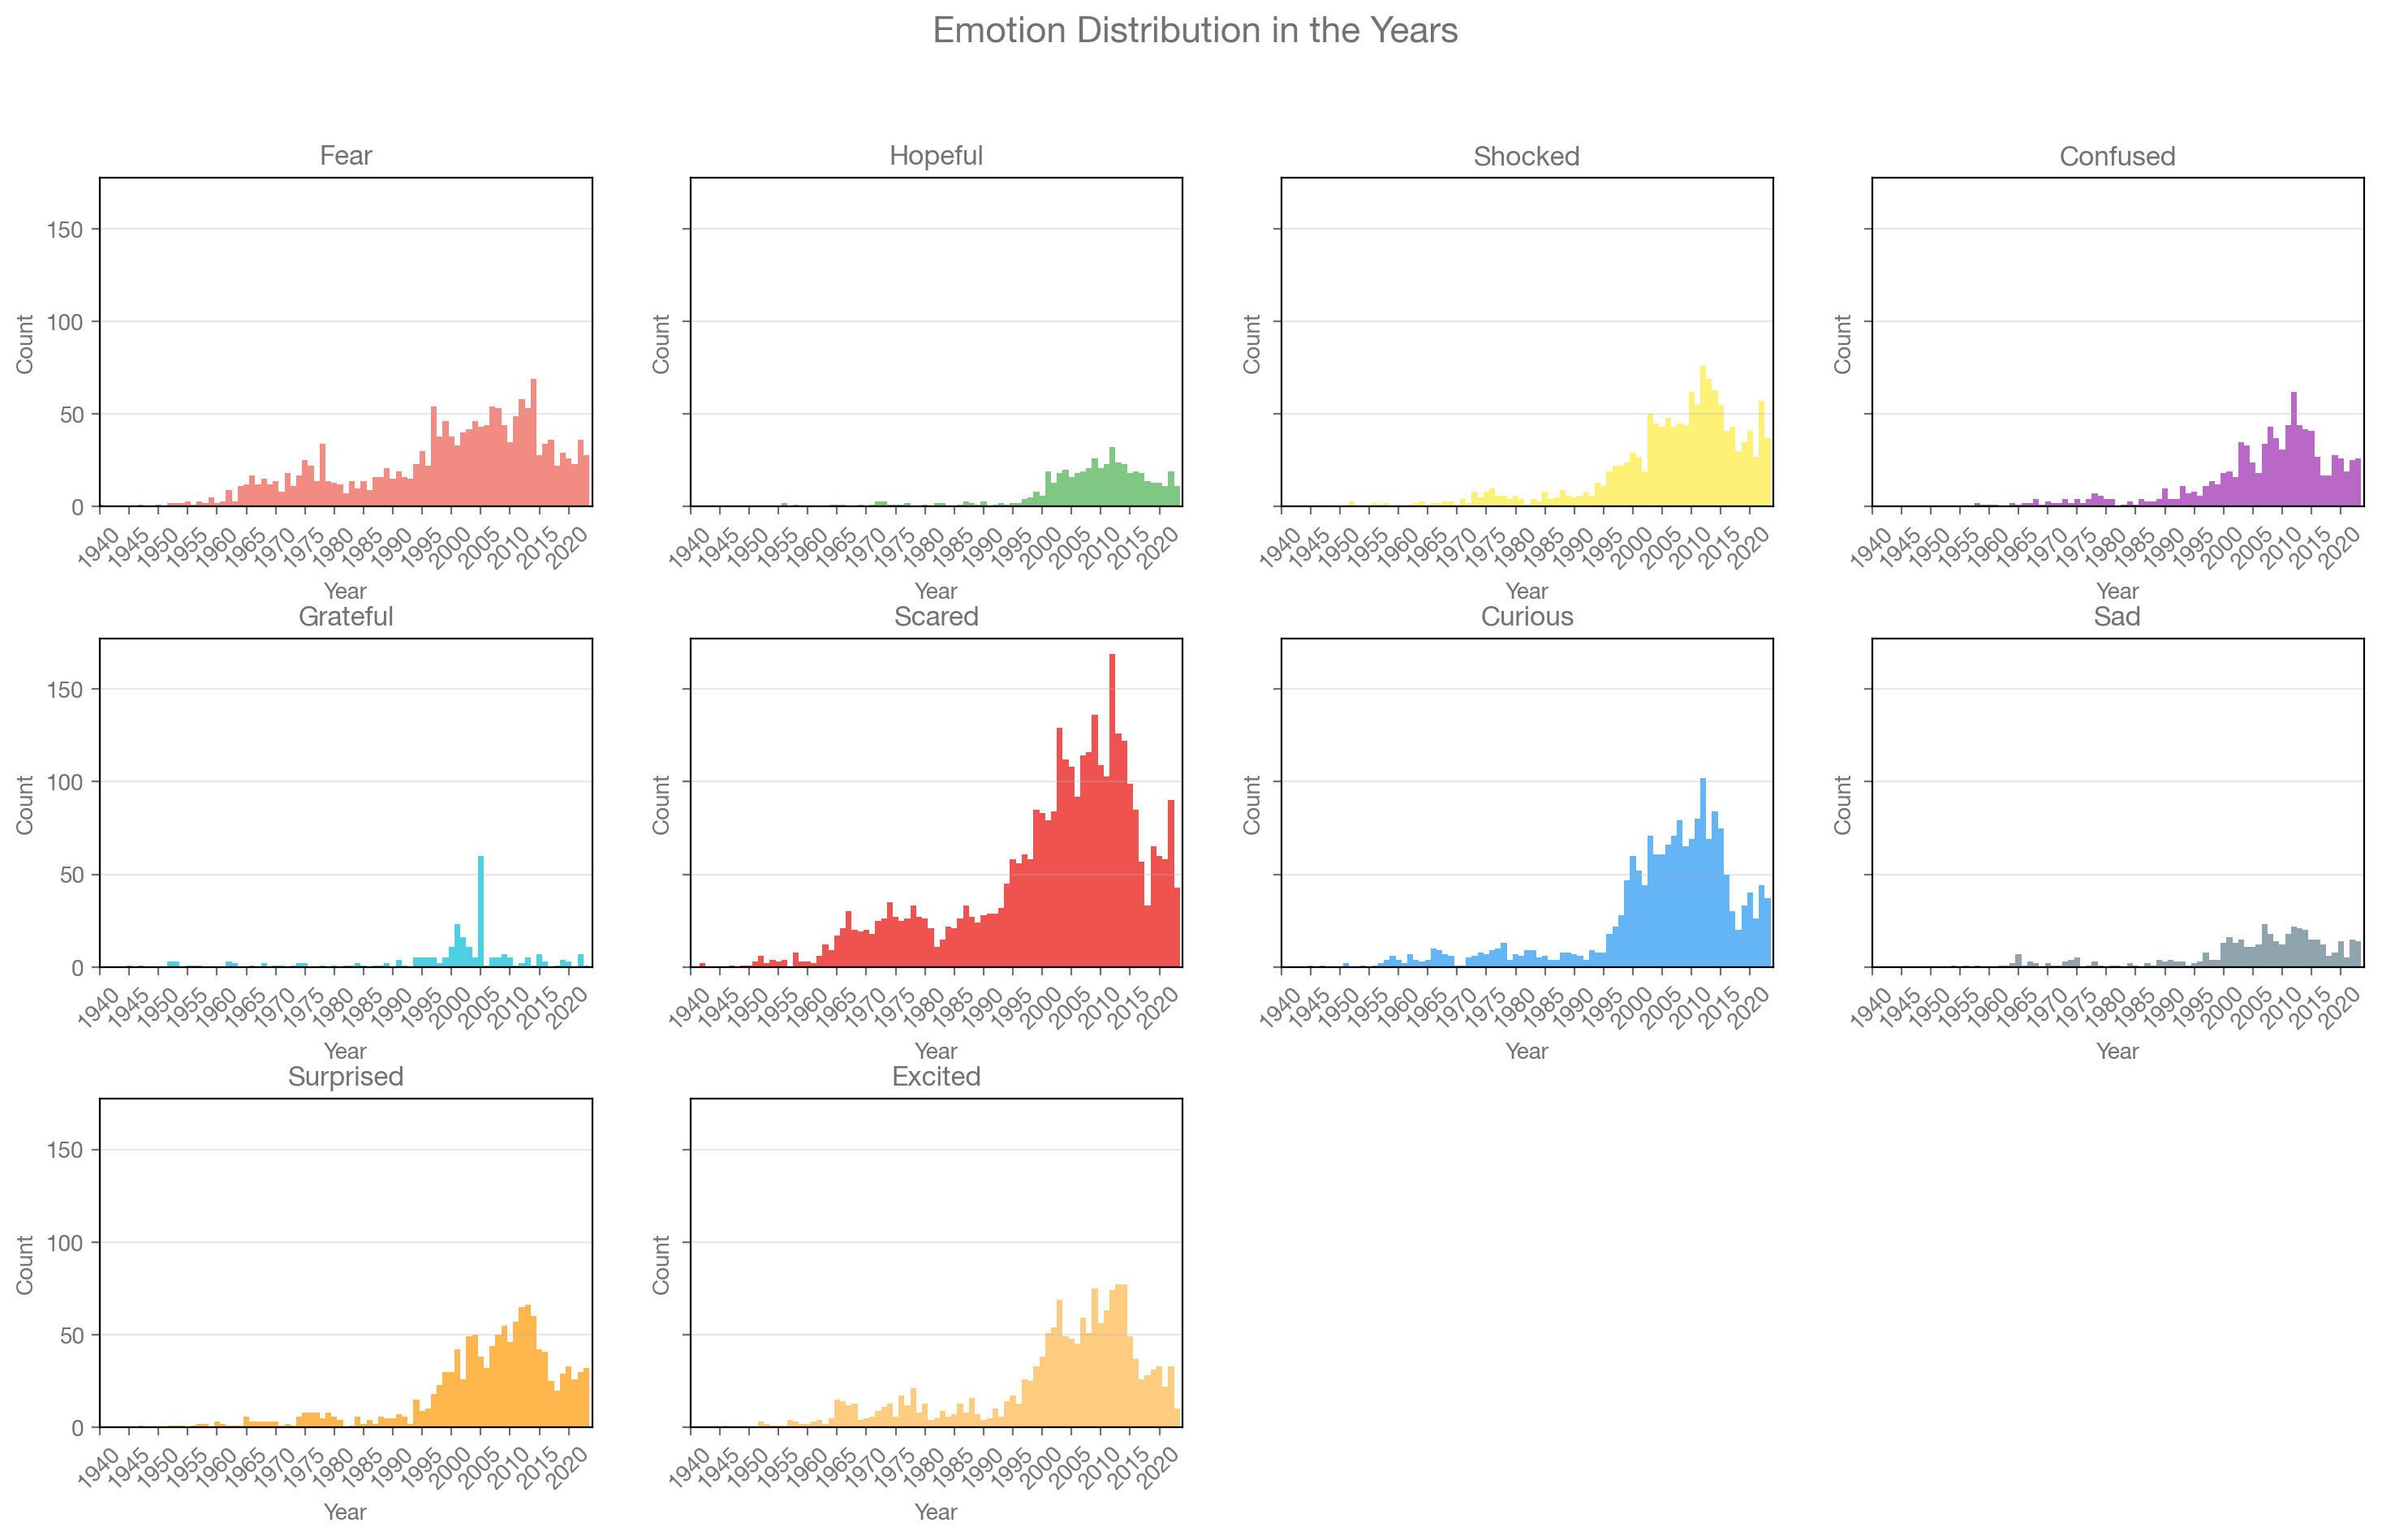

In [297]:
fig, axes = plt.subplots(3, 4, figsize=(18, 10), sharey=True)

# Define the year range
min_year = max(1940, int(df_sent['datetime'].dt.year.min()))
max_year = min(2024, int(df_sent['datetime'].dt.year.max()))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['year', 'count']
    
    ax.bar(
        df_emotion_count['year'], 
        df_emotion_count['count'], 
        color=emotion_colors.get(e),
        width=1.0
    )
    ax.set_title(e.capitalize())
    ax.set_xlabel('Year')
    ax.set_xticks(range(min_year, max_year, 5))
    ax.set_xticklabels(range(min_year, max_year, 5), rotation=45)
    ax.set_xlim(min_year, max_year + 1)
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Emotion Distribution in the Years', fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

All emotions observe an increase after the years 2000, probably due to the spread of information in social medias and the ease of reporting through internet (when was the website opened?). Nevertheless, all of them peaked in 2012 (why?) with a subsequent decrease.
Fear and scare appears to be by far the most frequent emotions in the time 1940-2000.

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, RangeTool, Legend, CustomJS
from bokeh.layouts import column
from bokeh.io import output_notebook

output_notebook()

# Prepare data for each emotion
emotion_data = {}
for emotion in emotion_keywords:
    df_emotion = df_sent[df_sent[emotion] == True]
    df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['year', 'count']
    emotion_data[emotion] = ColumnDataSource(df_emotion_count)

# Create the main Bokeh figure
p = figure(
    title="Occurrences of Emotions per Year",
    height=300, width=650,
    x_axis_label='Year', y_axis_label='Count',
    x_range=(2000, 2023)
)

p.xaxis.ticker = list(range(1940, 2025, 1))  # one tick per year
p.xaxis.major_label_orientation = 0.785  # 45 degrees in radians

p.add_layout(Legend(), 'right')

# Create the range selection tool
select = figure(
    title="Drag the middle and edges of the selection box to change the range above.\nAlso use the legend to show or hide lines.",
    height=130, width=650, y_range=p.y_range,
    x_range=(min_year, max_year),
    tools="", toolbar_location=None,
)

renderers_p = []
renderers_select = []

# Add a line for each emotion to both plots, and keep references to renderers
for emotion in emotion_keywords:
    source = emotion_data[emotion]
    r1 = p.line(
        x='year', y='count', source=source, line_width=2,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.8,
        legend_label=emotion.capitalize()
    )
    r2 = select.line(
        x='year', y='count', source=source, line_width=1,
        color=emotion_colors.get(emotion, 'blue'), alpha=0.5,
    )
    renderers_p.append(r1)
    renderers_select.append(r2)

# Set up legend
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.5
select.grid.grid_line_alpha = 0.3

# Add RangeTool
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2
select.add_tools(range_tool)

# Synchronize visibility between main plot and select plot
# This uses a CustomJS callback to link the visibility of lines
for r1, r2 in zip(renderers_p, renderers_select):
    r1.js_link('visible', r2, 'visible')

show(column(p, select))

Loading BokehJS ...

Looking at the chart, there’s a weird spike in all emotions in 2022, followed by a quick drop afterwards (why?).

“Fear” is clearly the most common emotion across the board, especially around 2012 and again in 2022. People mostly seem scared or unsettled by what they see. “Curious” is next, staying fairly steady, though sometimes “Excited” overtakes it.

“Grateful” stands out as the least mentioned emotion, with small bumps in 2001 and 2005 (why?). “Hopeful” and “Sad” seem to move together over time, possibly reflecting similar emotional tones in the reports.

In general, while fear dominates, the mix of emotions tells us that these sightings can trigger a wide range of reactions — from awe to confusion to genuine excitement.

#### Prediction of scared in the years

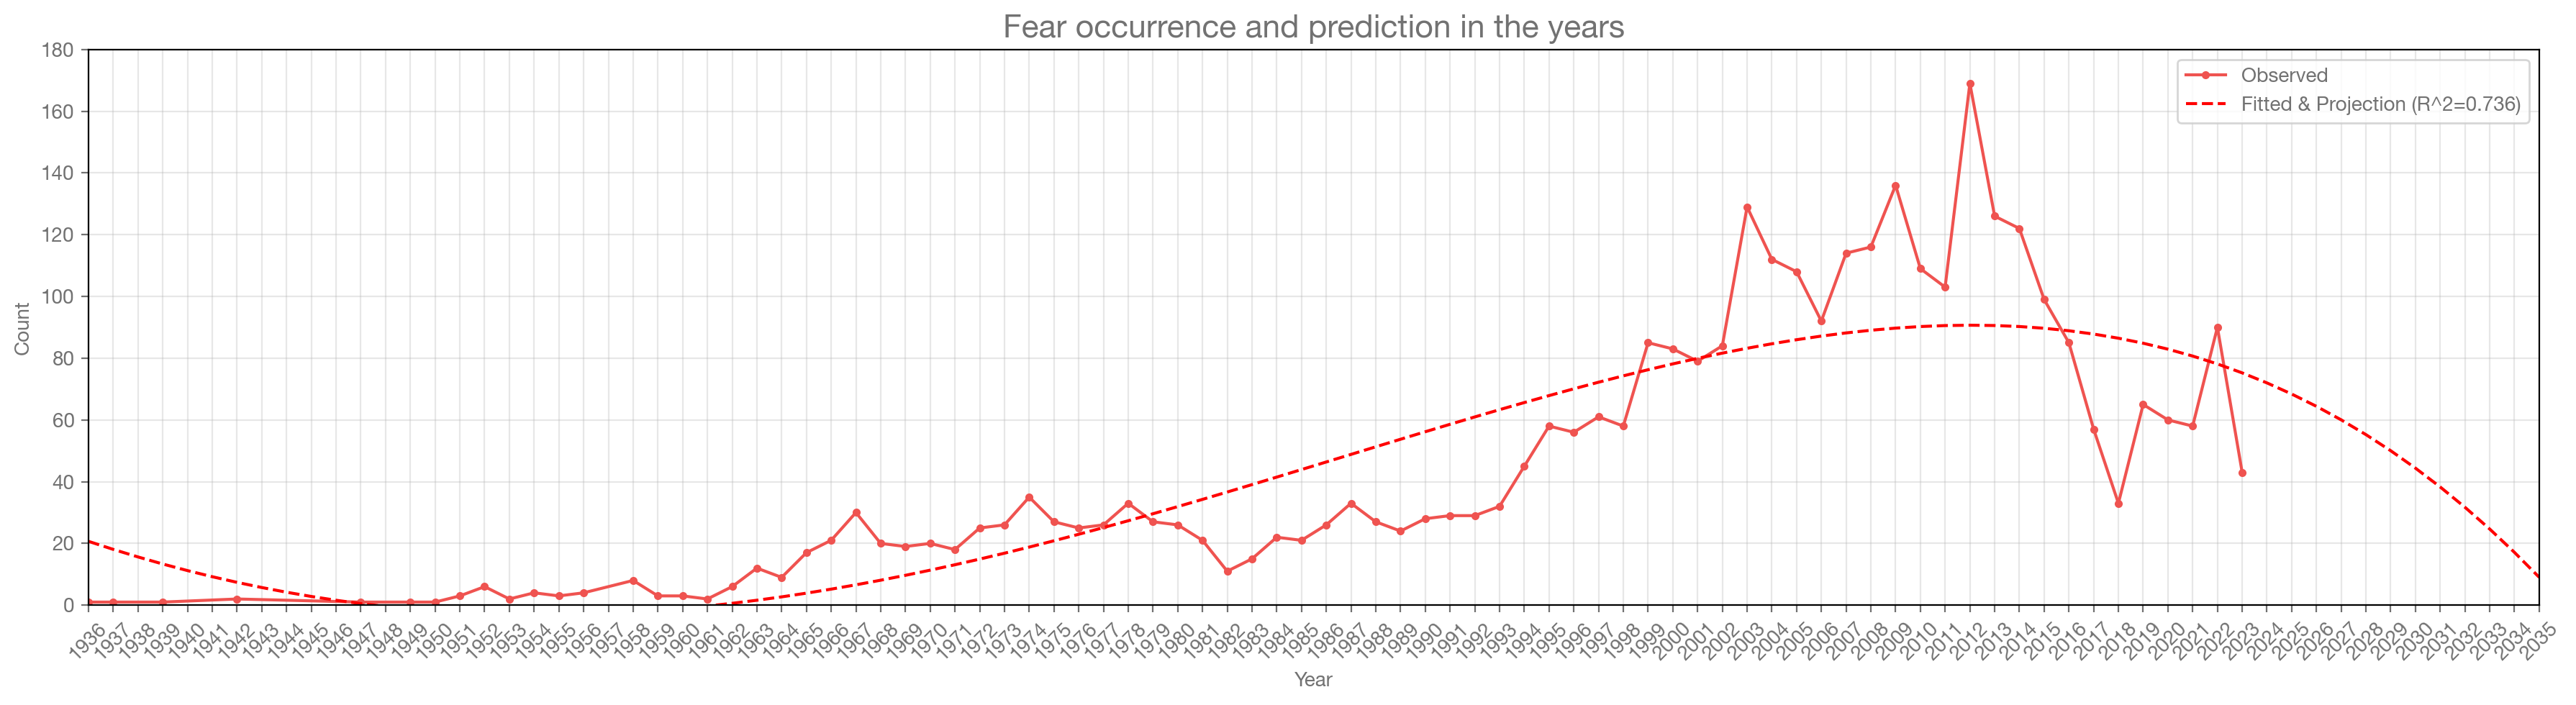

In [299]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Prepare data
df_emotion = df_sent[df_sent['scared'] == True]
df_emotion_count = df_emotion['datetime'].dt.year.value_counts().sort_index().reset_index()
df_emotion_count.columns = ['year', 'count']

min_year = int(df_emotion['datetime'].dt.year.min())
max_year = max(2036, int(df_emotion['datetime'].dt.year.max()))

# Fit a polynomial regression (degree=2 for a curve)
X = df_emotion_count['year'].values.reshape(-1, 1)
y = df_emotion_count['count'].values
poly = PolynomialFeatures(degree=20)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)
r2 = model.score(X_poly, y)

# Predict for all years (observed + future)
all_years = np.arange(min_year, max_year).reshape(-1, 1)
all_X_poly = poly.transform(all_years)
all_counts = model.predict(all_X_poly)

# Plot observed, fitted, and projection
plt.figure(figsize=(18, 5))
plt.plot(df_emotion_count['year'], df_emotion_count['count'], marker='o', markersize=3, label='Observed', color=emotion_colors.get('scared'))
plt.plot(all_years.flatten(), all_counts, 'r--', label=f'Fitted & Projection (R^2={r2:.3f})')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Fear occurrence and prediction in the years', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(min_year, max_year), rotation=45)
plt.xlim(min_year, max_year - 1)
plt.ylim(0, max(max(df_emotion_count['count']), int(all_counts.max()) * 2))
plt.tight_layout()
plt.show()

Fitting a curve on the observed data, seems like that the frightening effect of sightings will be gone by 2035.

### Emotion vs Most occurring words

#### (ignore) By emotion
Apparently no relevant differences

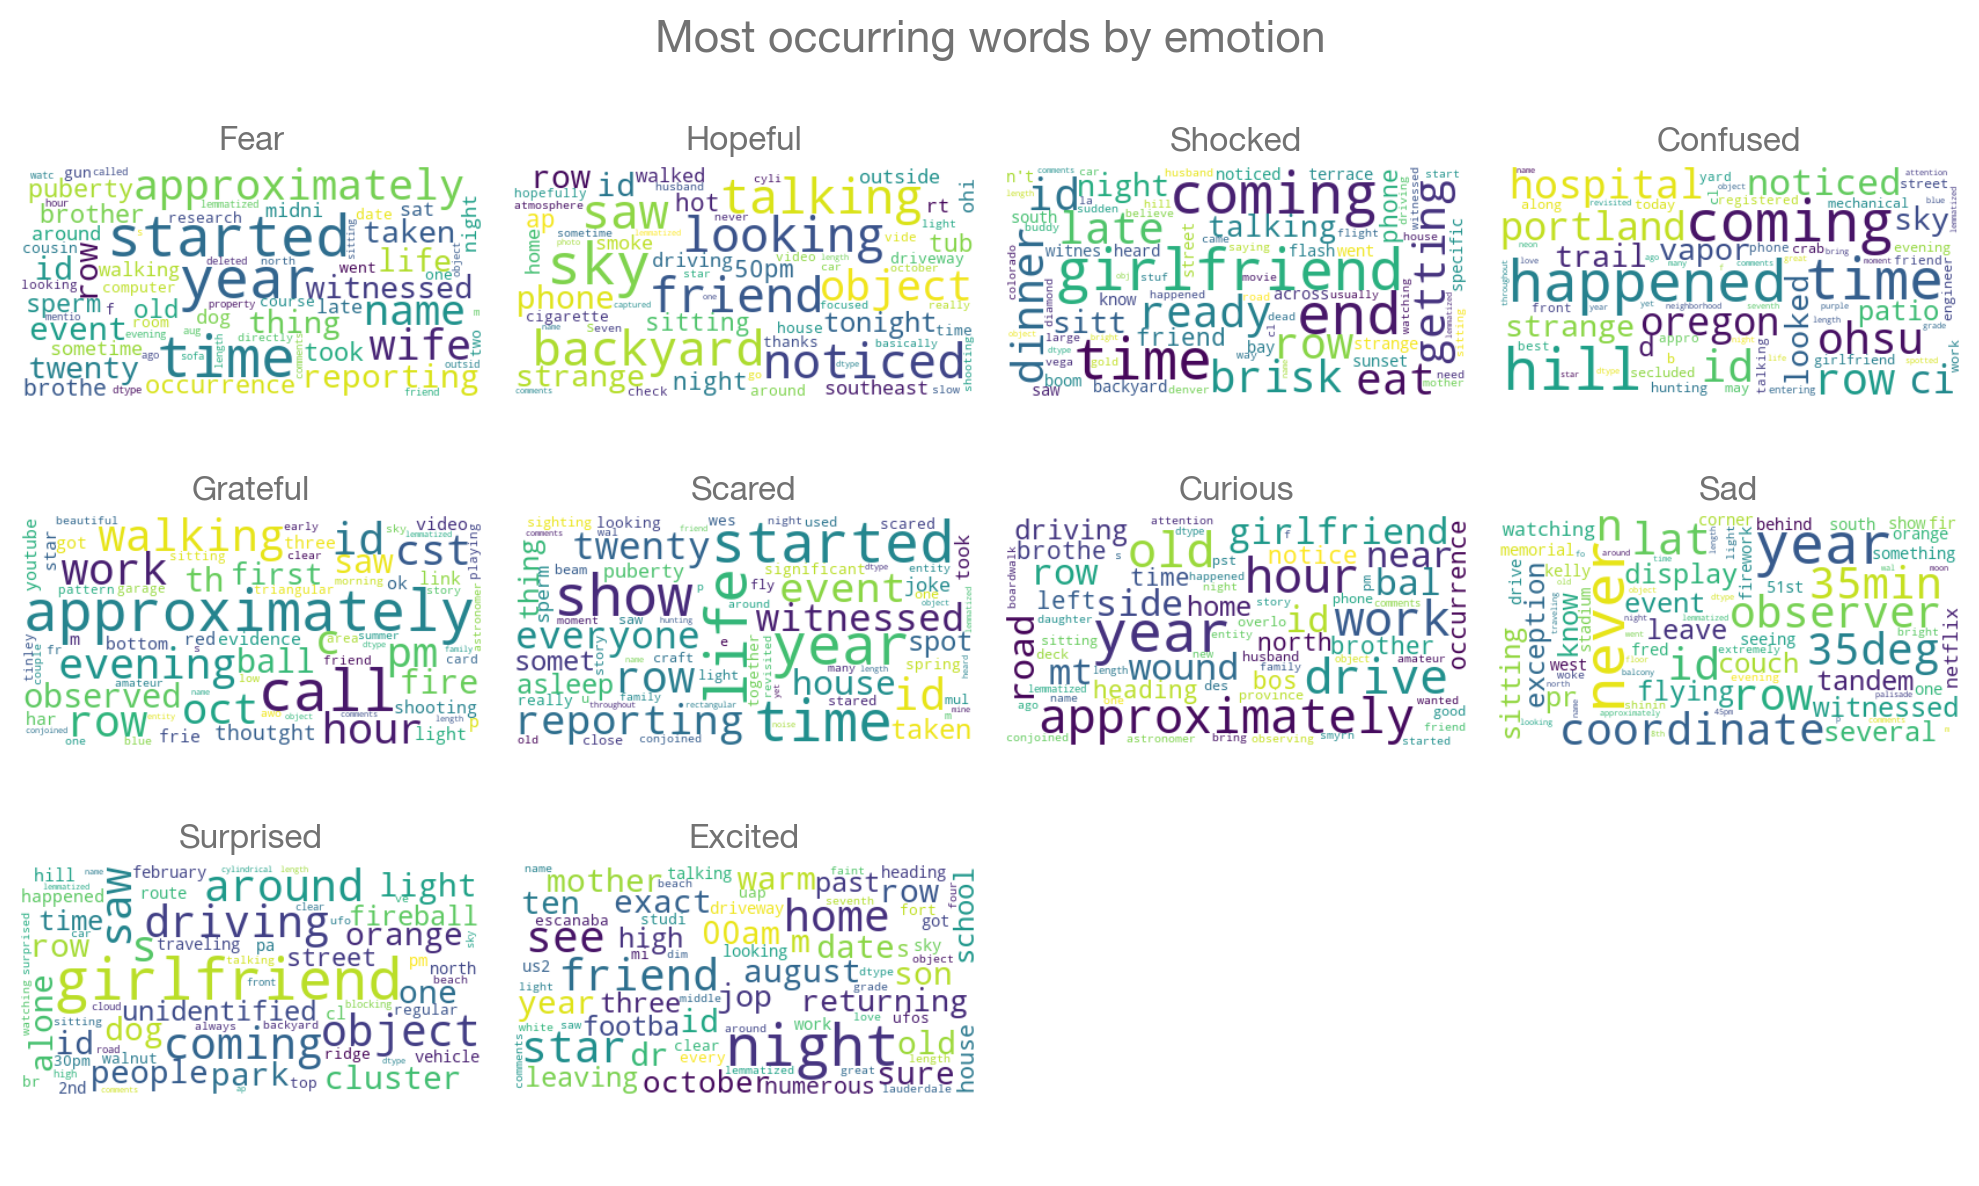

In [300]:
from wordcloud import WordCloud
 
fig, axes = plt.subplots(3, 4, figsize=(10, 6))

for ax, e in zip(axes.flatten(), emotion_keywords):
    subset = df_sent[df_sent[e] == True]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(subset['lemmatized comments']).lower())
    ax.set_title(e.capitalize())
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

fig.suptitle('Most occurring words by emotion', fontsize=16)
plt.tight_layout()
plt.show()

#### Regardless of the emotion

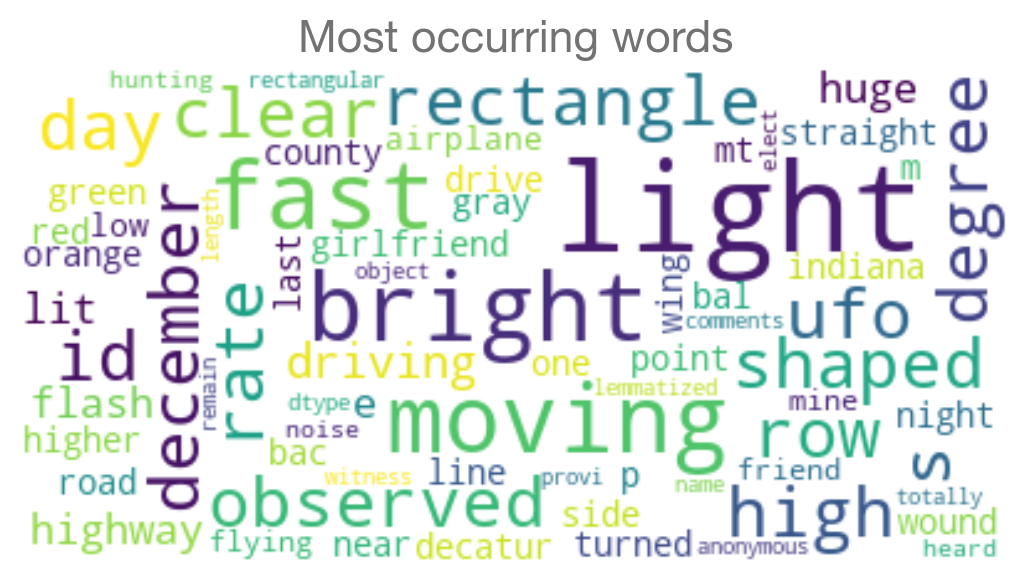

In [301]:
from wordcloud import WordCloud
 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_sent['lemmatized comments']).lower())
plt.title('Most occurring words', fontsize=16)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### (ignore) Emotion vs Shape
Again not relevant based on emotion

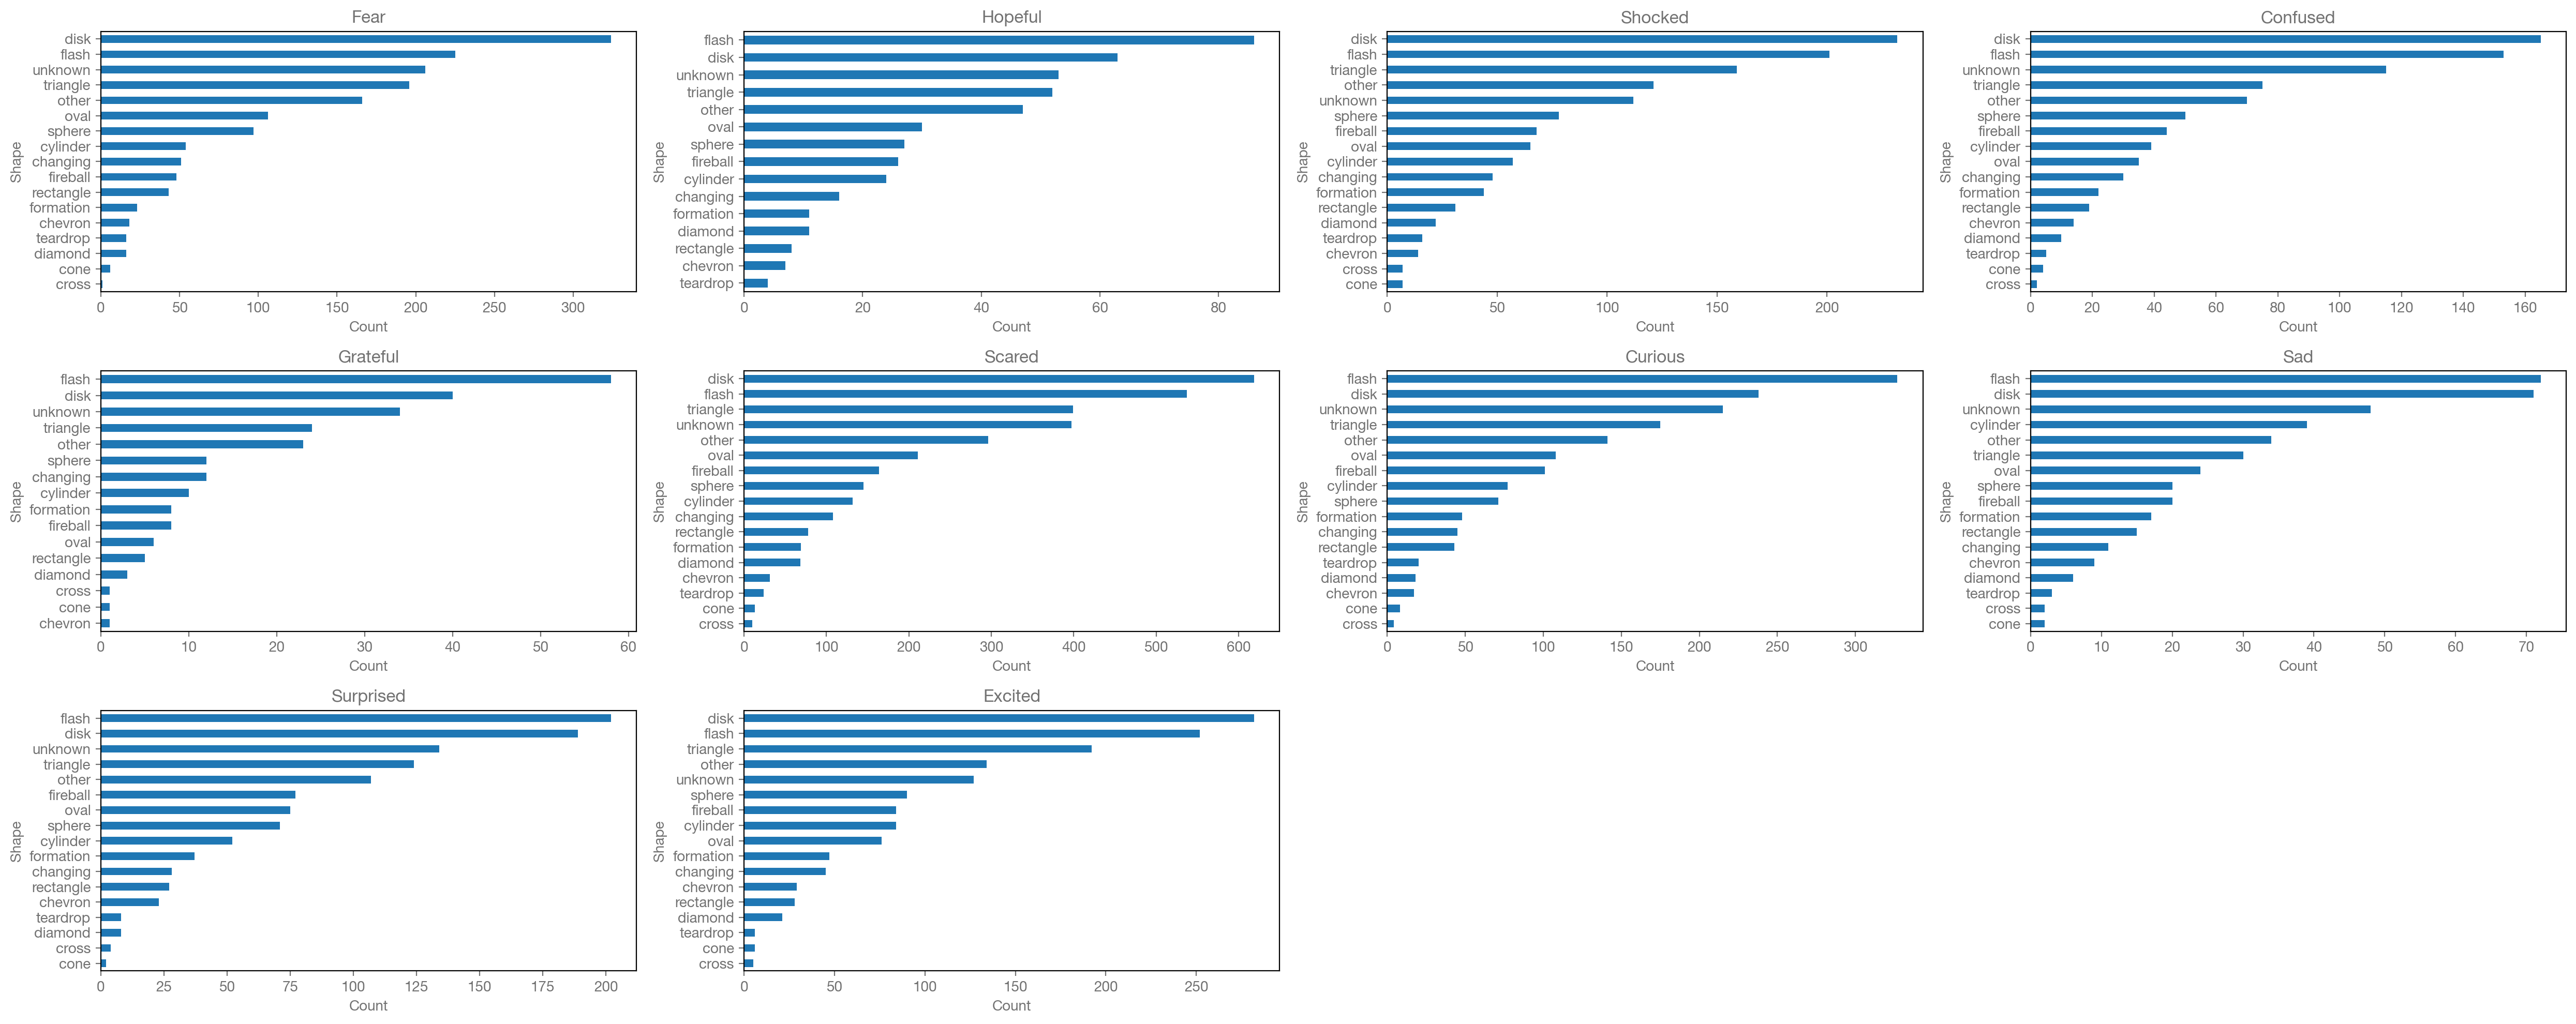

In [302]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    df_emotion.groupby('shape')['shape'].count().sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Count')
    ax.set_ylabel('Shape')

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Emotion vs Duration

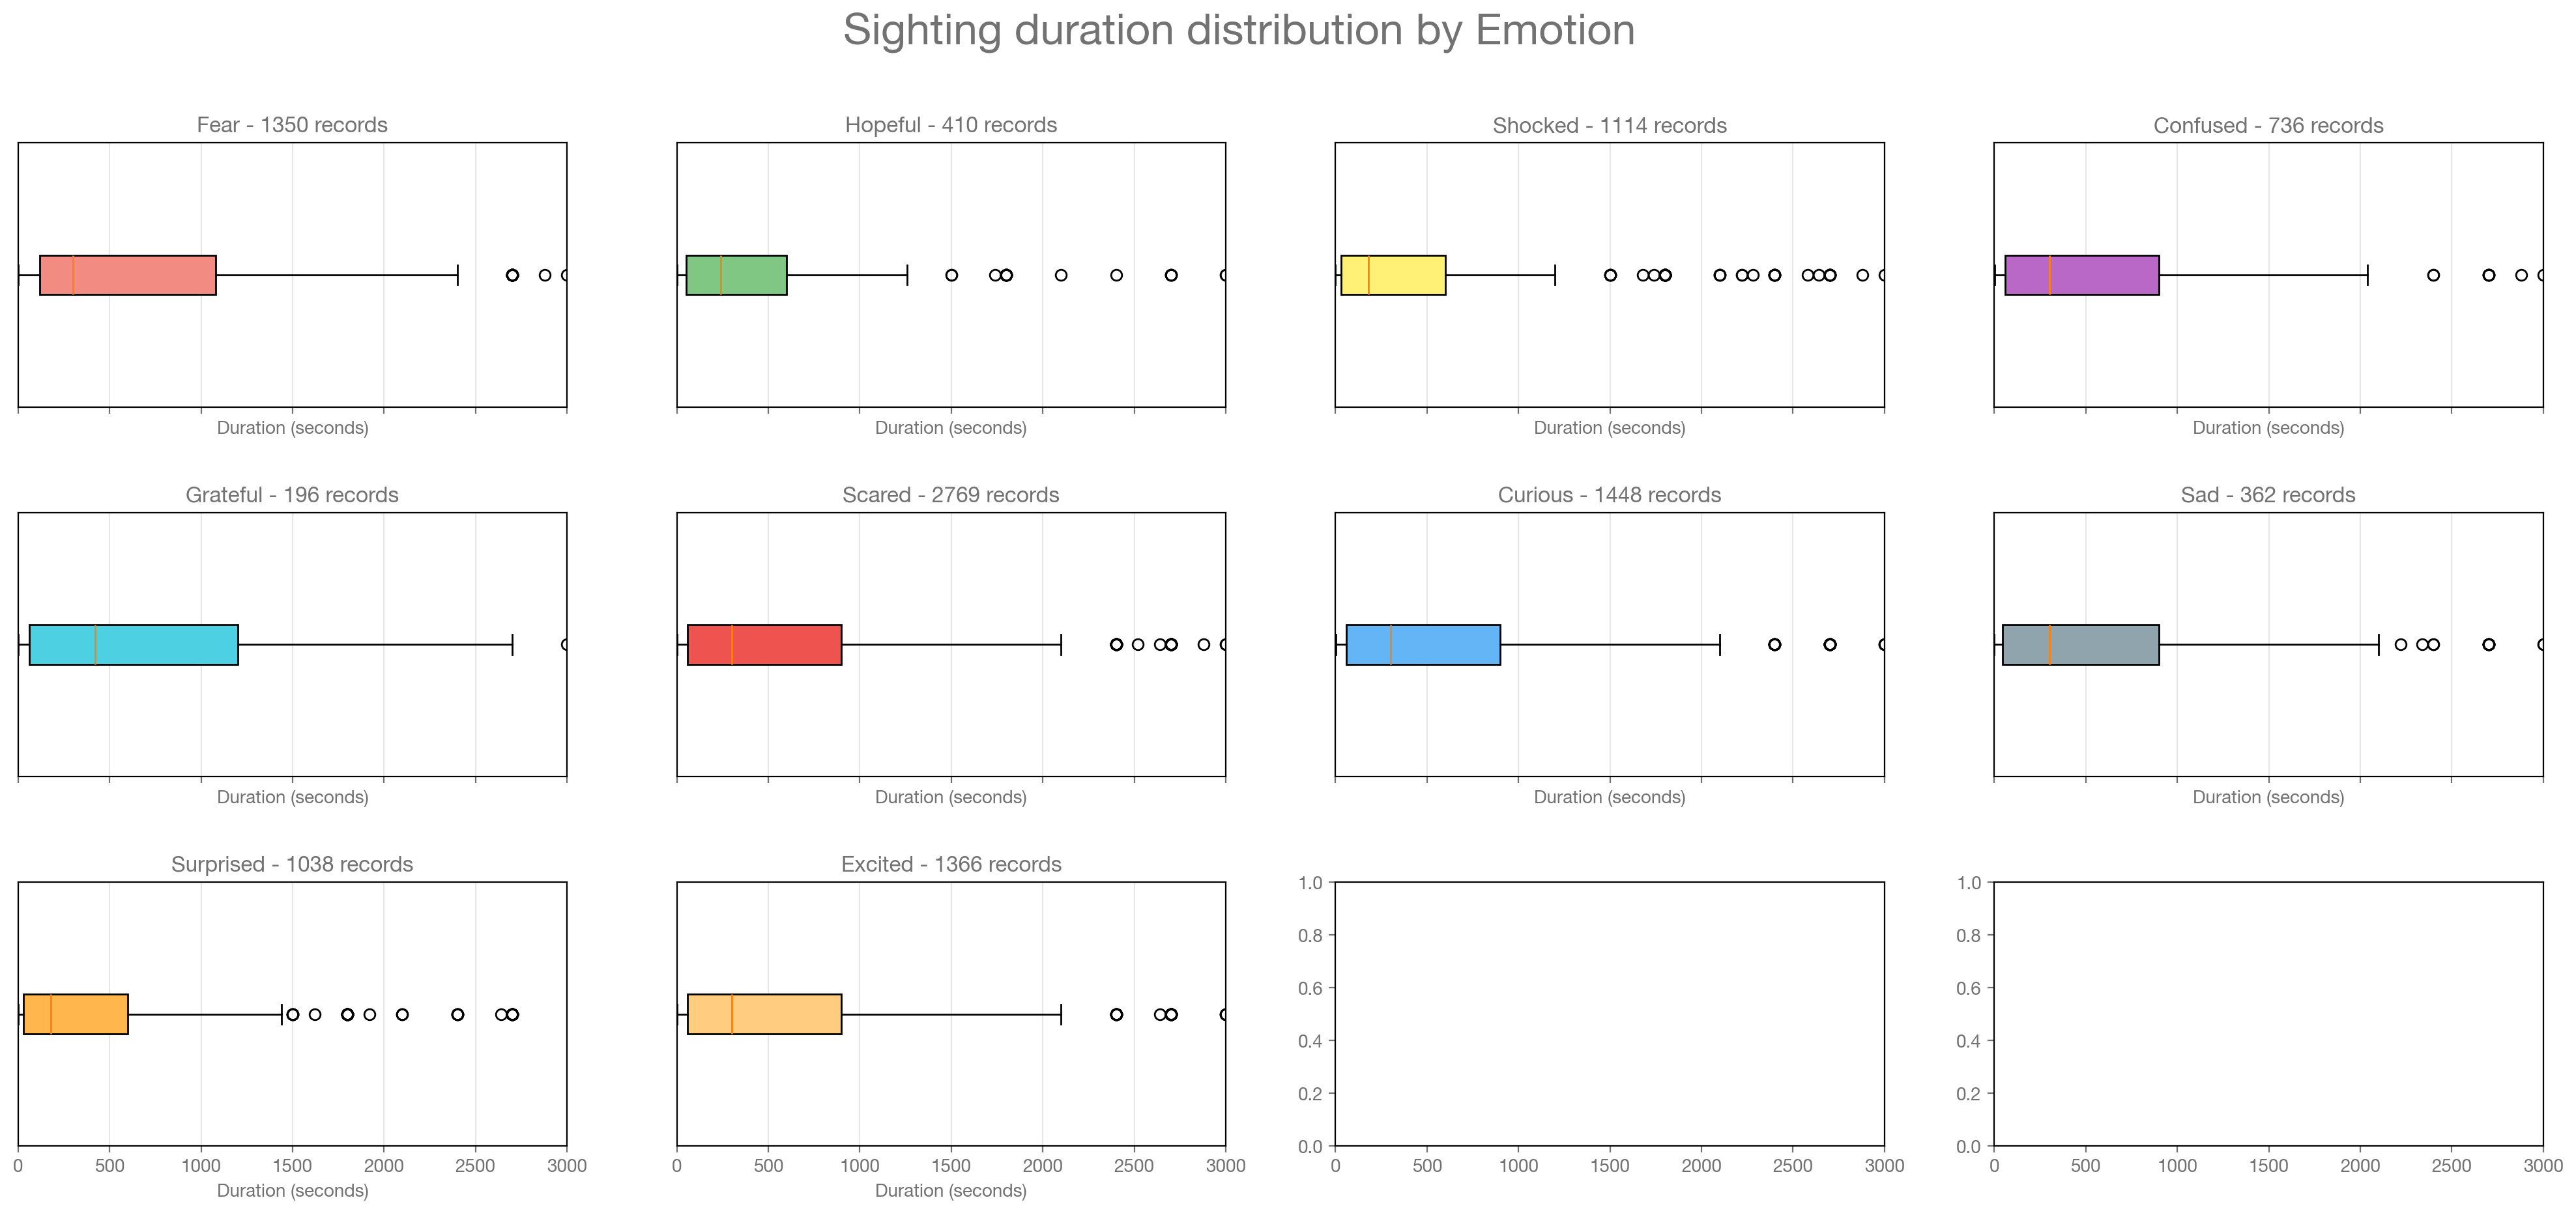

In [303]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10), sharex=True)

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True].copy().dropna(subset=['duration'])

    ax.boxplot(
        df_emotion['duration'], 
        vert=False, 
        patch_artist=True, 
        boxprops=dict(facecolor=emotion_colors.get(e))
    )
    ax.set_title(f'{e.capitalize()} - {len(df_emotion)} records')
    ax.set_xlabel('Duration (seconds)')
    ax.set_xlim(0, 3000)  # Set x-axis limit for better visibility
    ax.set_yticks([])  # Remove y-axis ticks for clarity
    ax.grid(axis='x', alpha=0.3)  # Add grid lines for x-axis

fig.suptitle('Sighting duration distribution by Emotion', fontsize=24)
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

The longest average durations come from Grateful and Fear. You can see it clearly in the position of their boxes — the upper quartiles are visibly higher than most others. Hopeful and Shocked are among the shortest, with their boxes packed tightly near the start of the x-axis.

Whiskers also tell a story: Grateful, Scared and Curious have long whiskers, meaning their durations vary a lot. Hopeful and Shocked seem to follow the same trend as before, having much shorter whiskers: those emotions show up in more uniform, shorter sightings.

As for outliers, Shocked and Surprised stand out. They show a bunch of scattered dots after the right whisker, even though their core durations are short — looks like rare, long events push those emotions over the edge.